In [72]:
# Import library yang kalian butuhkan
import os
import cv2 as cv
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.model_selection import train_test_split, cross_val_predict
from sklearn.metrics import accuracy_score, classification_report
from skimage.feature import graycomatrix, graycoprops
from sklearn.metrics import accuracy_score, precision_score, recall_score, f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.svm import SVC
from scipy.stats import entropy
import seaborn as sns


## Data Loading

In [38]:
# data = []
# labels = []
# paths = []
# file_name = []

# for sub_folder in os.listdir("dataset\\"):
#     sub_folder_files = os.listdir(os.path.join("dataset\\", sub_folder))
#     for i, filename in enumerate(sub_folder_files):
#         img_path = os.path.join("dataset\\", sub_folder, filename)
#         img = cv.imread(img_path)
        
#         if img is None:  # Cek apakah gambar terbaca dengan benar
#             print(f"Failed to read image {img_path}")
#             continue  # Lanjutkan ke gambar berikutnya
        
#         resized_img = cv.resize(img, (256, 256))  # Resize gambar menjadi 256x256 piksel
#         data.append(resized_img)  # Tambahkan gambar yang di-resize, bukan gambar asli
#         labels.append(sub_folder)
#         paths.append(img_path)
#         name = os.path.splitext(filename)[0]
#         file_name.append(filename)
        
#         # Membuat direktori output jika belum ada
#         output_dir = os.path.join("resizeImage\\", sub_folder) 
#         if not os.path.exists(output_dir):
#             os.makedirs(output_dir)
        
#         # Menyimpan gambar yang di-resize ke direktori output
#         cv.imwrite(os.path.join(output_dir, filename), resized_img)

# print("Image processing complete.")


In [39]:
data = []
labels = []
paths = []
file_name = []
for sub_folder in os.listdir("resizeImage\\"):
    sub_folder_files = os.listdir(os.path.join("resizeImage\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("resizeImage\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
        data.append(img)
        labels.append(sub_folder)
        paths.append(img_path)
        name = os.path.splitext(filename)[0]
        file_name.append(filename)
        
data = np.array(data)
labels = np.array(labels)
paths = np.array(paths)



## Data Preparation

### Data Augmentation

In [40]:
data_augmented = []
labels_augmented = []
paths_augmented = []
file_name_augmented = []
for i in range(len(data)):
	data_augmented.append(data[i])
	labels_augmented.append(labels[i])
	paths_augmented.append(paths[i])
	file_name_augmented.append(file_name[i])
	data_augmented.append(cv.rotate(data[i], cv.ROTATE_90_CLOCKWISE))
	labels_augmented.append(labels[i])
	paths_augmented.append(paths[i])
	file_name_augmented.append(file_name[i])

In [41]:
print("Data sebelum augmentasi: ", len(data))
print("Data setelah augmentasi: ", len(data_augmented))

Data sebelum augmentasi:  2099
Data setelah augmentasi:  4198


### Preprocessing

In [42]:
def bgr2gray(image):
    tinggi, lebar = image.shape[:2]
    grayImg = np.zeros((tinggi, lebar)).astype(np.uint8)
    for i in range(tinggi):
        for j in range(lebar):
            grayImg[i,j] = int(0.2989*image[i][j][2] + 0.5870*image[i][j][1] + 0.1140*image[i][j][0])
            
    return grayImg

In [43]:
def mergeRGB(red, green, blue):
    return np.dstack((red, green, blue)).astype(np.uint8)

def masking(image, mask):
    new_img = image.copy()
    new_img[mask == 0] = 0
    return new_img

def bgr2hsv(image):
    tinggi, lebar = image.shape[:2]
    hsvImg = np.zeros((tinggi, lebar, 3)).astype(np.uint8)
    for i in range(tinggi):
        for j in range(lebar):
            b, g, r = image[i][j]
            r, g, b = r/255.0, g/255.0, b/255.0
            cmax = max(r, g, b)
            cmin = min(r, g, b)
            delta = cmax - cmin
            if delta == 0:
                h = 0
            elif cmax == r:
                h = 30 * (((g-b)/delta) % 6)
            elif cmax == g:
                h = 30 * (((b-r)/delta) + 2)
            elif cmax == b:
                h = 30 * (((r-g)/delta) + 4)
            if cmax == 0:
                s = 0
            else:
                s = delta / cmax
            v = cmax
            hsvImg[i,j] = [h, s*255, v*255]
    return hsvImg

def inRange(hsv, lower_color, upper_color):
    mask = np.logical_and(hsv >= lower_color, hsv <= upper_color)
    return np.all(mask, axis=-1).astype(np.uint8) * 255

In [44]:
def remove_background(img):
    hsv = cv.cvtColor(img, cv.COLOR_BGR2HSV)
    lower_color = np.array([20, 0, 20])
    upper_color = np.array([150, 200, 255])
    mask = inRange(hsv, lower_color, upper_color)
    res = cv.bitwise_and(img, img, mask=mask)
    tinggi, lebar = res.shape[:2]
    imageRes= np.full((tinggi, lebar), 255)
    imageRes[res[:,:,0] != 0] = 0
    red = masking(img[:,:,2], imageRes)
    green = masking(img[:,:,1], imageRes)
    blue = masking(img[:,:,0], imageRes)
    hasil = mergeRGB(blue, green, red)
    return hasil

In [45]:
for sub_folder in os.listdir("resizeImage\\"):
    sub_folder_files = os.listdir(os.path.join("resizeImage\\", sub_folder))
    for i, filename in enumerate(sub_folder_files):
        img_path = os.path.join("resizeImage\\", sub_folder, filename)
        img = cv.imread(img_path)
        img = img.astype(np.uint8)
        img = remove_background(img) 
        name = os.path.splitext(filename)[0]
        output_dir = os.path.join("hasilprosescobadulu\\", sub_folder)
        if not os.path.exists(output_dir):
            os.makedirs(output_dir)
        cv.imwrite(os.path.join(output_dir, filename), img)


### Feature Extraction

In [46]:
def glcm(image, derajat):
    if derajat == 0:
        angles = [0]
    elif derajat == 45:
        angles = [np.pi / 4]
    elif derajat == 90:
        angles = [np.pi / 2]
    elif derajat == 135:
        angles = [3 * np.pi / 4]
    else:
        raise ValueError("Invalid angle. It should be one of the following: 0, 45, 90, 135.")
    
    glcm = graycomatrix(image, [1], angles, 256, symmetric=True, normed=True)
    return glcm

In [47]:
def correlation(matriks):
	return graycoprops(matriks, 'correlation')[0, 0]

In [48]:
def dissimilarity(matriks):
    return graycoprops(matriks, 'dissimilarity')[0, 0]

In [49]:
def homogenity(matriks):
    return graycoprops(matriks, 'homogeneity')[0, 0]

In [50]:
def contrast(matriks):
    return graycoprops(matriks, 'contrast')[0, 0]

In [51]:
def ASM(matriks):
    return graycoprops(matriks, 'ASM')[0, 0]

In [52]:
def energy(matriks):
    return graycoprops(matriks, 'energy')[0, 0]

In [53]:
def entropyGlcm(matriks):
    return entropy(matriks.ravel())

In [54]:
Derajat0 = []
Derajat45 = []
Derajat90 = []
Derajat135 = []
for i in range(len(data_augmented)):
    D0 = glcm(data_augmented[i], 0)
    D45 = glcm(data_augmented[i], 45)
    D90 = glcm(data_augmented[i], 90)
    D135 = glcm(data_augmented[i], 135)
    Derajat0.append(D0)
    Derajat45.append(D45)
    Derajat90.append(D90)
    Derajat135.append(D135)

In [55]:
Kontras0, Kontras45, Kontras90, Kontras135 = [], [], [], []
dissimilarity0, dissimilarity45, dissimilarity90, dissimilarity135 =  [], [], [], []
homogenity0, homogenity45, homogenity90, homogenity135 = [], [], [], []
entropy0, entropy45, entropy90, entropy135 =  [], [], [], []
ASM0, ASM45, ASM90, ASM135 =  [], [], [], []
energy0, energy45, energy90, energy135 =  [], [], [], []
correlation0, correlation45, correlation90, correlation135 = [], [], [], []


In [56]:
for i in range(len(data)):
    C0 = correlation(Derajat0[i])
    correlation0.append(C0)
    C45 = correlation(Derajat45[i])
    correlation45.append(C45)
    C90 = correlation(Derajat90[i])
    correlation90.append(C90)
    C135 = correlation(Derajat135[i])
    correlation135.append(C135)

In [57]:
for i in range(len(data)):
    K0 = contrast(Derajat0[i])
    K45 = contrast(Derajat45[i])
    K90 = contrast(Derajat90[i])
    K135 = contrast(Derajat135[i])
    Kontras0.append(K0)
    Kontras45.append(K45)
    Kontras90.append(K90)
    Kontras135.append(K135)

In [58]:
for i in range(len(data)):
    Dis0 = dissimilarity(Derajat0[i])
    Dis45 = dissimilarity(Derajat45[i])
    Dis90 = dissimilarity(Derajat90[i])
    Dis135 = dissimilarity(Derajat135[i])
    dissimilarity0.append(Dis0)
    dissimilarity45.append(Dis45)
    dissimilarity90.append(Dis90)
    dissimilarity135.append(Dis135)

In [59]:
for i in range(len(data)):
    H0 = homogenity(Derajat0[i])
    H45 = homogenity(Derajat45[i])
    H90 = homogenity(Derajat90[i])
    H135 = homogenity(Derajat135[i])
    homogenity0.append(H0)
    homogenity45.append(H45)
    homogenity90.append(H90)
    homogenity135.append(H135)

In [60]:
for i in range(len(data)):  
    E0 = entropyGlcm(Derajat0[i])
    E45 = entropyGlcm(Derajat45[i])
    E90 = entropyGlcm(Derajat90[i])
    E135 = entropyGlcm(Derajat135[i])
    entropy0.append(E0)
    entropy45.append(E45)
    entropy90.append(E90)
    entropy135.append(E135)

In [61]:
for i in range(len(data)):
    A0 = ASM(Derajat0[i])
    A45 = ASM(Derajat45[i])
    A90 = ASM(Derajat90[i])
    A135 = ASM(Derajat135[i])
    ASM0.append(A0)
    ASM45.append(A45)
    ASM90.append(A90)
    ASM135.append(A135)

In [62]:
for i in range(len(data)):
    ER0 = energy(Derajat0[i])
    ER45 = energy(Derajat45[i])
    ER90 = energy(Derajat90[i])
    ER135 = energy(Derajat135[i])
    energy0.append(ER0)
    energy45.append(ER45)
    energy90.append(ER90)
    energy135.append(ER135)

In [63]:
dataTable = {'Filename': file_name, 'Label': labels,
        'Contrast0': Kontras0, 'Contrast45': Kontras45, 'Contrast90': Kontras90, 'Contrast135': Kontras135,
        'Homogeneity0': homogenity0, 'Homogeneity45': homogenity45, 'Homogeneity90': homogenity90, 'Homogeneity135': homogenity135,
        'Dissimilarity0': dissimilarity0, 'Dissimilarity45': dissimilarity45, 'Dissimilarity90': dissimilarity90, 'Dissimilarity135': dissimilarity135,
        'Entropy0': entropy0, 'Entropy45': entropy45, 'Entropy90': entropy90, 'Entropy135': entropy135,
        'ASM0': ASM0, 'ASM45': ASM45, 'ASM90': ASM90, 'ASM135': ASM135,
        'Energy0': energy0, 'Energy45': energy45, 'Energy90': energy90, 'Energy135': energy135,
        'Correlation0': correlation0, 'Correlation45': correlation45, 'Correlation90': correlation90, 'Correlation135': correlation135,
        }
df = pd.DataFrame(dataTable)
df.to_csv('hasil_ekstraksi_1.csv', index=False)

hasilEkstrak = pd.read_csv('hasil_ekstraksi_1.csv')
hasilEkstrak


,Filename,Label,Contrast0,Contrast45,Contrast90,Contrast135,Homogeneity0,Homogeneity45,Homogeneity90,Homogeneity135,...,ASM90,ASM135,Energy0,Energy45,Energy90,Energy135,Correlation0,Correlation45,Correlation90,Correlation135
0,00_f1d021110_1_1.jpg,finger_1,6.055239,8.215609,3.509988,9.398693,0.707965,0.611543,0.666278,0.604153,...,0.011033,0.009285,0.113992,0.096877,0.105039,0.096358,0.995450,0.993794,0.997340,0.992900
1,00_f1d021110_1_2.jpg,finger_1,3.509988,9.398693,6.055239,8.215609,0.666278,0.604153,0.707965,0.611543,...,0.012994,0.009385,0.105039,0.096358,0.113992,0.096877,0.997340,0.992900,0.995450,0.993794
2,01_F1D022016_1_1.jpg,finger_1,129.299586,149.597755,50.187194,172.482215,0.381834,0.337686,0.429487,0.333217,...,0.001186,0.000881,0.032765,0.029861,0.034441,0.029689,0.971094,0.966544,0.988752,0.961426
3,01_F1D022016_1_2.jpg,finger_1,50.187194,172.482215,129.299586,149.597755,0.429487,0.333217,0.381834,0.337686,...,0.001074,0.000892,0.034441,0.029689,0.032765,0.029861,0.988752,0.961426,0.971094,0.966544
4,01_F1D022016_1_3.jpg,finger_1,59.294516,82.245075,39.797258,56.891734,0.344807,0.310815,0.349500,0.313685,...,0.003257,0.002798,0.056768,0.053109,0.057073,0.052897,0.972635,0.962083,0.981599,0.973771
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2094,7_F1D022144_5_2.jpg,finger_5,201.327129,264.414025,212.029197,340.253287,0.357635,0.307034,0.334656,0.294008,...,0.001375,0.001175,0.040270,0.034485,0.037075,0.034277,0.965034,0.954126,0.963173,0.940967
2095,7_F1D022144_5_3.jpg,finger_5,212.029197,340.253287,201.327129,264.414025,0.334656,0.294008,0.357635,0.307034,...,0.001622,0.001189,0.037075,0.034277,0.040270,0.034485,0.963173,0.940967,0.965034,0.954126
2096,IMG_20240523_184654.jpg,finger_5,103.873453,104.420823,33.529044,134.555110,0.477832,0.418614,0.479232,0.402081,...,0.002485,0.002011,0.051928,0.045551,0.049848,0.044841,0.987935,0.987881,0.996102,0.984384
2097,IMG_20240523_184659.jpg,finger_5,33.529044,134.555110,103.873453,104.420823,0.479232,0.402081,0.477832,0.418614,...,0.002697,0.002075,0.049848,0.044841,0.051928,0.045551,0.996102,0.984384,0.987935,0.987881


### Features Selection

<Axes: >

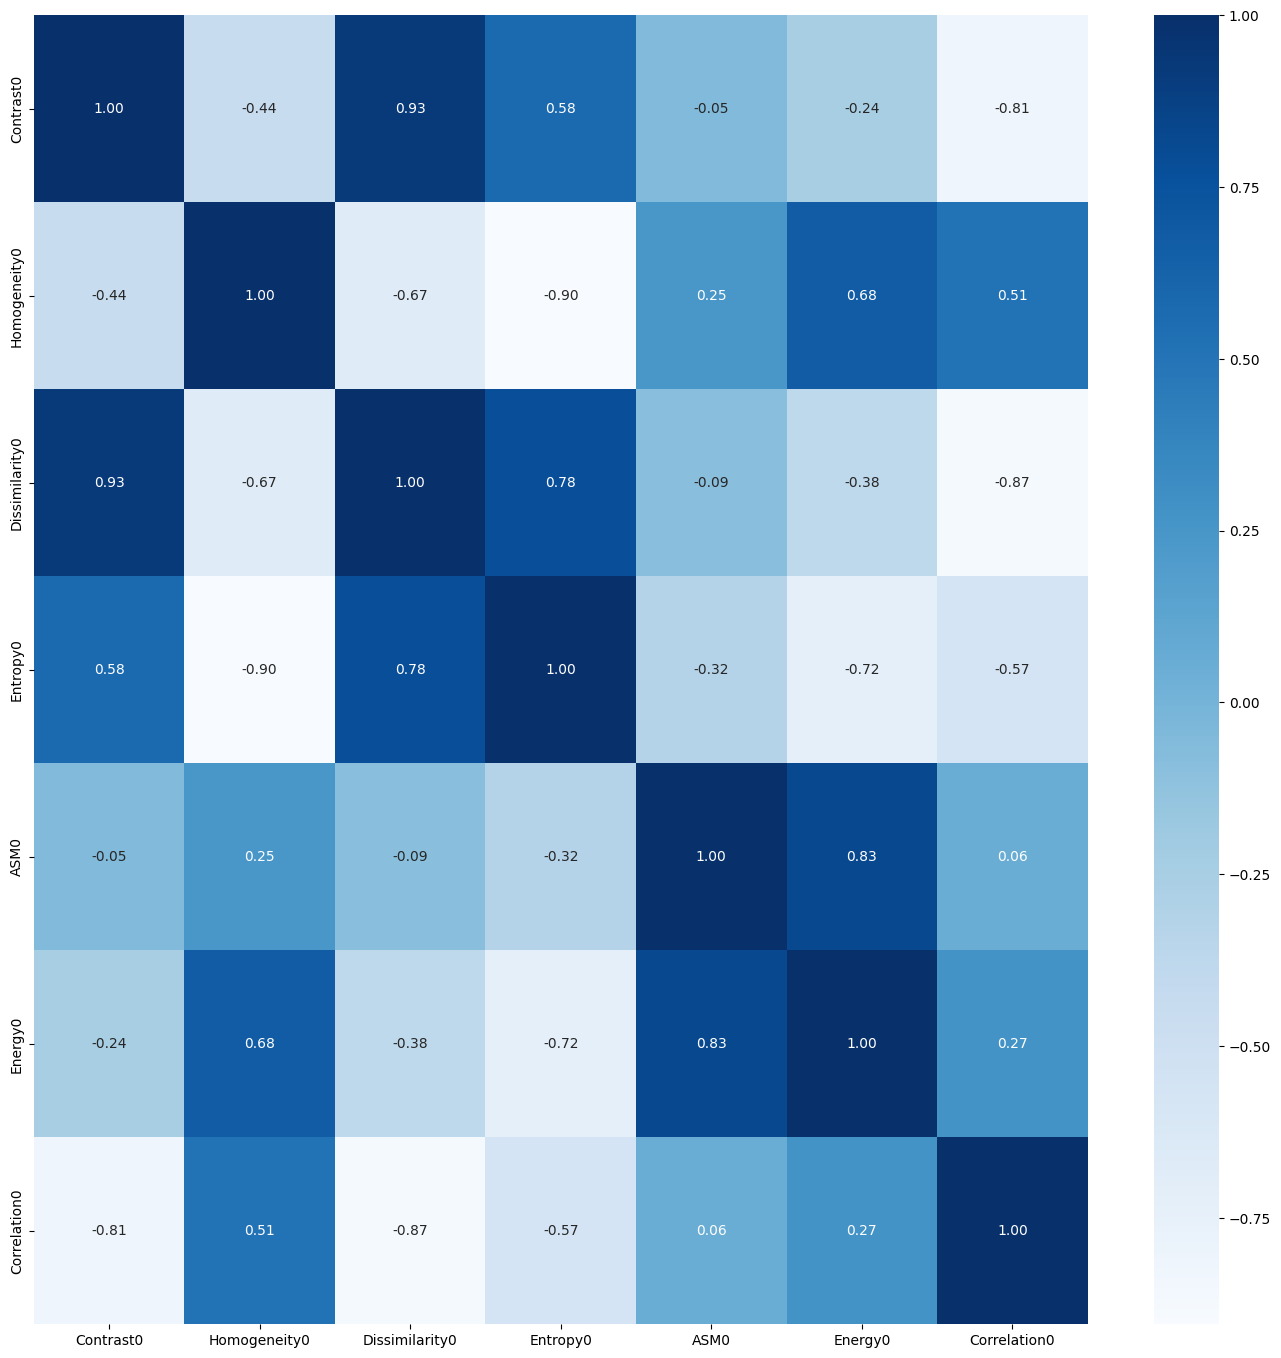

In [64]:
correlation = hasilEkstrak.drop(columns=['Label','Filename']).corr()

threshold = 0.95
selectionFeature = []
columns = np.full((correlation.shape[0],), True, dtype=bool)
for i in range(correlation.shape[0]):
	for j in range(i+1, correlation.shape[0]):
		if correlation.iloc[i,j] >= threshold:
			if columns[j]:
				columns[j] = False
select = hasilEkstrak.drop(columns=['Label','Filename']).columns[columns]
x_new = hasilEkstrak[select]
x_new
y = hasilEkstrak['Label']
plt.figure(figsize=(17,17))
sns.heatmap(x_new.corr(), annot=True, cmap='Blues', fmt=".2f")

### Splitting Data

In [65]:
X_train, X_test, y_train, y_test = train_test_split(x_new, y, test_size=0.3, random_state=42)
print(X_train)
print(X_test)

        Contrast0  Homogeneity0  Dissimilarity0  Entropy0      ASM0   Energy0  \
905    532.667984      0.118855       14.649449  8.757803  0.000247  0.015730   
199     45.495083      0.229480        4.617203  7.742992  0.000849  0.029137   
1301    22.773208      0.657248        1.552956  5.508805  0.014847  0.121847   
1776  1341.487760      0.060452       25.793367  9.636052  0.000093  0.009666   
1223    40.464338      0.540232        2.109865  7.117308  0.002048  0.045260   
...           ...           ...             ...       ...       ...       ...   
1638   256.015901      0.183738        7.832629  8.568946  0.000308  0.017539   
1095    15.037040      0.665496        1.528585  5.479174  0.019648  0.140170   
1130    28.921752      0.681922        1.774173  5.338646  0.021011  0.144950   
1294    55.772610      0.634184        2.072304  5.603408  0.012529  0.111932   
860    356.455683      0.112315       12.297718  9.310851  0.000131  0.011450   

      Correlation0  
905   

### Normalization

In [68]:
X_test = (X_test - X_train.mean()) / X_train.std()
X_train = (X_train - X_train.mean()) / X_train.std()

## Modeling

In [73]:
def crossValidation(x, y, model):
    y_pred = cross_val_predict(model, x, y, cv=20)
    accuracy = accuracy_score(y, y_pred)
    precision = precision_score(y, y_pred, average='macro', zero_division=1)
    recall = recall_score(y, y_pred, average='macro')
    f1 = f1_score(y, y_pred, average='macro')
    print(f'Accuracy: {accuracy * 100:.2f}%')
    print(f'Precision: {precision * 100:.2f}%')
    print(f'Recall: {recall * 100:.2f}%')
    print(f'F1 Score: {f1 * 100:.2f}%')
    return y_pred, accuracy, precision, recall, f1


print("KNN")
y_pred_knn, akurasiKNN, presisiKNN, recallKNN, f1KNN = crossValidation(x_new, y, KNeighborsClassifier(n_neighbors=20))

print("\nRandom Forest")
y_pred_rforest, akurasiRForest, presisiRForest, recallRForest, f1RForest = crossValidation(x_new, y, RandomForestClassifier(n_estimators=175, random_state=50))

print("\nSVM")
y_pred_svm, akurasiSVM, presisiSVM, recallSVM, f1SVM = crossValidation(x_new, y, SVC(kernel='rbf', random_state=42))

KNN
Accuracy: 20.68%
Precision: 20.88%
Recall: 20.67%
F1 Score: 20.59%

Random Forest
Accuracy: 19.20%
Precision: 19.08%
Recall: 19.20%
F1 Score: 19.09%

SVM
Accuracy: 22.01%
Precision: 17.95%
Recall: 21.96%
F1 Score: 15.89%


## Evaluation

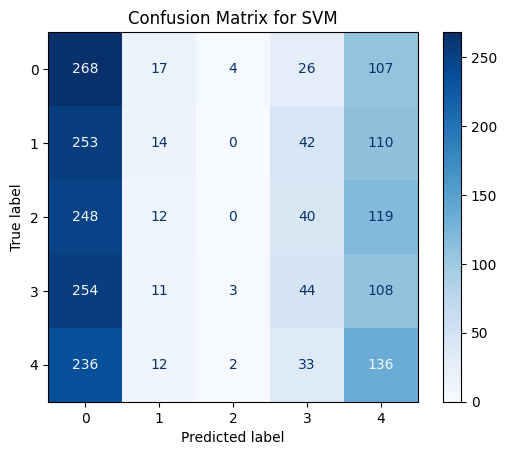

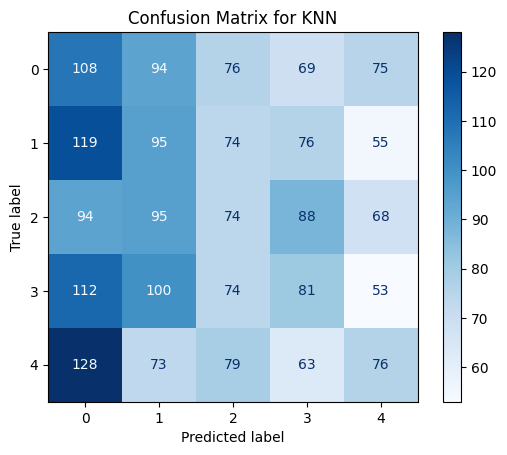

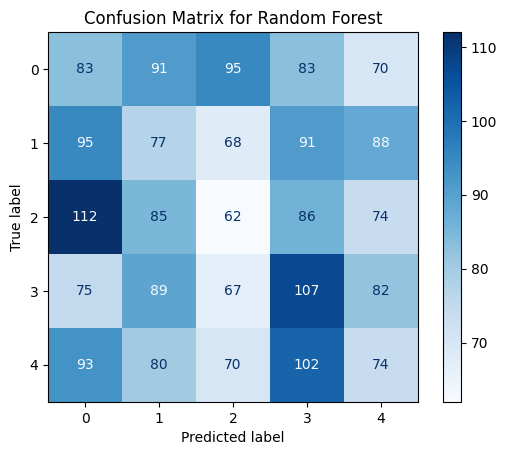

In [74]:
from sklearn.metrics import (confusion_matrix, ConfusionMatrixDisplay)

def plot_confusion_matrix(y_true, y_pred, title):
    cm = confusion_matrix(y_true, y_pred)
    disp = ConfusionMatrixDisplay(confusion_matrix=cm)
    disp.plot(cmap=plt.cm.Blues)
    plt.title(title)
    plt.show()

plot_confusion_matrix(y, y_pred_svm, 'Confusion Matrix for SVM')
plot_confusion_matrix(y, y_pred_knn, 'Confusion Matrix for KNN')
plot_confusion_matrix(y, y_pred_rforest, 'Confusion Matrix for Random Forest')